# Data Science Regression Project: Melanoma Tumor Size Prediction


## Loading Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, StackingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours

# Data Load: Melanoma Tumor Size into a dataframe

In [10]:
train = pd.read_csv(r'E:/Data_Sets/Train_15.csv')

In [11]:
train.head()

,mass_npea,size_npear,malign_ratio,damage_size,exposed_area,std_dev_malign,err_malign,malign_penalty,damage_ratio,tumor_size
0,6930.90,2919.02,0.42116,51.8298,9.888294e+05,109.487,2758.76,72,39.3620,14.103
1,15635.70,4879.36,0.31206,223.5500,2.058426e+06,248.881,5952.53,240,22.0253,2.648
2,10376.20,2613.88,0.25191,127.3370,1.434676e+06,160.093,4635.26,73,29.9963,1.688
3,13093.80,4510.06,0.34444,155.4400,1.812195e+06,173.015,5273.87,32,28.1354,3.796
4,7545.21,2882.36,0.38201,85.1237,1.043918e+06,124.414,3263.35,57,35.0200,18.023


In [12]:
train.describe()

,mass_npea,size_npear,malign_ratio,damage_size,exposed_area,std_dev_malign,err_malign,malign_penalty,damage_ratio,tumor_size
count,9146.000000,9146.000000,9146.000000,9146.000000,9.146000e+03,9146.000000,9146.000000,9146.000000,9146.000000,9146.000000
mean,9903.052174,3032.827837,0.303083,103.902118,1.372442e+06,146.304239,3992.936256,69.849661,34.461652,7.723348
std,4060.577116,1462.334147,0.062533,55.456862,5.646773e+05,70.512177,1780.672859,55.785332,5.972808,6.086852
min,2864.760000,510.530000,0.114820,10.310100,3.878534e+05,31.970400,1089.190000,0.000000,15.228000,0.000000
25%,6988.420000,1983.657500,0.259053,64.012525,9.596873e+05,95.853900,3177.682500,31.000000,30.290225,2.320000
50%,8895.965000,2684.330000,0.301055,88.458300,1.237057e+06,126.138500,3846.320000,54.000000,35.245750,5.060500
75%,12119.950000,3830.745000,0.343002,134.209000,1.693083e+06,182.251500,4664.577500,91.000000,38.806075,13.336000
max,36995.400000,13535.000000,0.525300,346.420000,4.978616e+06,528.890000,91983.700000,340.000000,46.546400,20.999000


In [13]:
target = train.pop('tumor_size')

## Transformation 

In [14]:
train[['mass_npea','size_npear','exposed_area','err_malign']] = np.log1p(train[['mass_npea','size_npear','exposed_area','err_malign']])
train.head()

,mass_npea,size_npear,malign_ratio,damage_size,exposed_area,std_dev_malign,err_malign,malign_penalty,damage_ratio
0,8.843889,7.979346,0.42116,51.8298,13.804278,109.487,7.922899,72,39.3620
1,9.657376,8.492974,0.31206,223.5500,14.537453,248.881,8.691740,240,22.0253
2,9.247366,7.868973,0.25191,127.3370,14.176450,160.093,8.441663,73,29.9963
3,9.479970,8.414287,0.34444,155.4400,14.410050,173.015,8.570709,32,28.1354
4,8.928801,7.966712,0.38201,85.1237,13.858492,124.414,8.090816,57,35.0200


# Feature Engineering

## Deriving new columns from the existing in order to have more information available for the model to learn so that it can perform with better accuracy

In [21]:
train['penalty-err'] = train['malign_penalty'] - train['err_malign']
train['d_size-ratio'] = train['damage_size'] - train['damage_ratio']
train['d_ratio-m_ratio'] = train['damage_ratio'] - (train['malign_ratio'])
train['penalty/std'] = train['malign_penalty']/train['std_dev_malign']
train['mass/area'] = (train['mass_npea'])/(train['exposed_area'])
train['area/mass'] = train['exposed_area']/train['mass_npea']
train['err/std'] = train['penalty-err']/train['std_dev_malign']
train['dsr/ps'] = train['damage_size']/train['penalty-err']
train['std/area'] = train['std_dev_malign']/train['exposed_area']
train['err/area'] = train['err_malign']/train['exposed_area']
train['dr/area'] = (train['damage_ratio']*100)/train['exposed_area']
train['std/err'] = (train['std_dev_malign']+1)/(train['err_malign']+1)
train['penalty/err'] = (train['malign_penalty']+1)/(train['err_malign']+1)

In [22]:
x_train = train.values
y_train = target.values

## Defining Metric

In [23]:
def RMSE(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))
rmse = make_scorer(RMSE, greater_is_better=False)

## Hyperparameter tuning of Extratrees Regressor using Bayesian optimization

In [24]:
def etc_cv(n_estimators, min_samples_split, max_features, data, target):
    estimator = ExtraTreesRegressor(
            n_estimators=n_estimators,
            min_samples_split=min_samples_split,
            max_features=max_features,
            random_state=2,
            n_jobs=-1
    )
    cval = cross_val_score(estimator, data, target, scoring=rmse, cv=5)
    
    return cval.mean()

In [25]:
def optimize_etc(data, target):
    def etc_crossval(n_estimators, min_samples_split, max_features):
        return etc_cv(
                n_estimators=int(n_estimators),
                min_samples_split=int(min_samples_split),
                max_features=max(min(max_features, 0.999), 1e-3),
                data=data,
                target=target,
                )
    optimizer = BayesianOptimization(
        f=etc_crossval,
        pbounds={
            "n_estimators":(100,550),
            "min_samples_split":(2,25),
            "max_features": (0.1,0.9)
        },
        random_state=42,
        verbose=2
    )
    optimizer.maximize(n_iter=15, init_points=10)
    
    print("Final result:", optimizer.max)

In [26]:
print(Colours.yellow("--- Optimizing Extra Trees ---"))
optimize_etc(x_train, y_train)

--- Optimizing Extra Trees ---
|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        | -4.108    |  0.3996   |  23.87    |  429.4    |
|  2        | -3.825    |  0.5789   |  5.588    |  170.2    |
|  3        | -4.225    |  0.1465   |  21.92    |  370.5    |
|  4        | -3.787    |  0.6665   |  2.473    |  536.5    |
|  5        | -3.835    |  0.766    |  6.884    |  181.8    |
|  6        | -3.921    |  0.2467   |  8.998    |  336.1    |
|  7        | -3.873    |  0.4456   |  8.698    |  375.3    |
|  8        | -3.948    |  0.2116   |  8.719    |  264.9    |
|  9        | -4.063    |  0.4649   |  20.06    |  189.9    |
|  10       | -3.986    |  0.5114   |  15.63    |  120.9    |
|  11       | -3.84     |  0.6767   |  7.548    |  175.7    |
|  12       | -3.881    |  0.9      |  10.75    |  541.0    |
|  13       | -3.803    |  0.3417   |  3.967    |  526.6    |
|  14       | -3.779    |  0.7611   |  

In [27]:
etc = ExtraTreesRegressor(n_estimators=int(389.1643211846736),
                         min_samples_split=int(2.169127366533436),
                         max_features=0.761053890090604,
                         n_jobs = -1,
                         random_state = 42)

## Hyperparameter tuning of RandomForest Regressor using Bayesian optimization

In [28]:
def rfc_cv(n_estimators, min_samples_split, max_features, data, target):
    estimator = RandomForestRegressor(
            n_estimators=n_estimators,
            min_samples_split=min_samples_split,
            max_features=max_features,
            random_state=42,
            n_jobs=-1
    )
    cval = cross_val_score(estimator, data, target, scoring=rmse, cv=5)
    
    return cval.mean()

In [29]:
def optimize_rfc(data, target):
    def rfc_crossval(n_estimators, min_samples_split, max_features):
        return rfc_cv(
            n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=max(min(max_features, 0.9), 1e-3),
            data=data,
            target=target,
            )
    optimizer = BayesianOptimization(
        f=rfc_crossval,
        pbounds={
            "n_estimators":(100,600),
            "min_samples_split":(2,25),
            "max_features":(0.1,0.9),
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=15, init_points=10)
    
    print("Final result:", optimizer.max)

In [30]:
print(Colours.green("--- Optimizing Random Forest ---"))
optimize_rfc(x_train, y_train)

--- Optimizing Random Forest ---
|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        | -4.054    |  0.2532   |  16.31    |  318.9    |
|  2        | -4.096    |  0.7283   |  19.94    |  236.3    |
|  3        | -4.078    |  0.3212   |  20.44    |  579.1    |
|  4        | -4.018    |  0.8007   |  10.23    |  350.5    |
|  5        | -4.086    |  0.6468   |  18.39    |  285.1    |
|  6        | -4.043    |  0.549    |  13.57    |  106.9    |
|  7        | -4.117    |  0.7183   |  22.3     |  282.4    |
|  8        | -3.945    |  0.5923   |  3.734    |  284.4    |
|  9        | -4.078    |  0.8465   |  16.98    |  298.6    |
|  10       | -4.005    |  0.731    |  9.287    |  384.0    |
|  11       | -3.925    |  0.3175   |  3.385    |  278.8    |
|  12       | -3.97     |  0.9      |  2.0      |  266.7    |
|  13       | -4.127    |  0.6755   |  24.99    |  407.5    |
|  14       | -4.211    |  0.1      |

In [31]:
rfc = RandomForestRegressor(n_estimators = int(278.823003027616),
                           min_samples_split=int(3.3847745086807413),
                           max_features = 0.31748183480254244,
                           n_jobs = -1, 
                           random_state = 42)

## Hyperparameter tuning of LightGradientBoosting Regressor using Bayesian optimization

In [32]:
def lgb_cv(n_estimators, num_leaves, min_child_samples, subsample, data, target):
    estimator = LGBMRegressor(
        n_estimators=n_estimators,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        subsample=subsample,
        random_state=2
    )
    cval = cross_val_score(estimator, data, target, scoring=rmse, cv=5)
    
    return cval.mean()

In [33]:
def optimize_lgb(data, targets):
    def lgb_crossval(n_estimators, num_leaves, min_child_samples, subsample):
        return lgb_cv(
            n_estimators=int(n_estimators),
            num_leaves= int(num_leaves),
            min_child_samples=int(min_child_samples),
            subsample=subsample,
            data=data,
            target=target,
        )
    
    optimizer = BayesianOptimization(
        f=lgb_crossval,
        pbounds={
            "n_estimators":(100,550),
            "num_leaves":(30,90),
            "min_child_samples":(5,30),
            "subsample":(0.6,1.0)
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=15, init_points=10)
    
    print("Final result:", optimizer.max)

In [34]:
print(Colours.blue("--- Optimizing Light GBM ---"))
optimize_lgb(x_train,y_train)

--- Optimizing Light GBM ---
|   iter    |  target   | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------
|  1        | -3.949    |  9.788    |  379.9    |  56.26    |  0.9141   |
|  2        | -3.989    |  24.5     |  222.7    |  46.59    |  0.9207   |
|  3        | -3.948    |  28.95    |  494.2    |  51.47    |  0.8004   |
|  4        | -3.959    |  22.09    |  420.7    |  52.22    |  0.8245   |
|  5        | -3.982    |  17.58    |  106.2    |  76.37    |  0.9531   |
|  6        | -3.986    |  14.12    |  376.9    |  34.52    |  0.7475   |
|  7        | -3.962    |  28.33    |  393.1    |  53.83    |  0.9155   |
|  8        | -3.929    |  12.92    |  355.6    |  82.15    |  0.7745   |
|  9        | -3.961    |  25.05    |  164.7    |  72.26    |  0.8818   |
|  10       | -3.931    |  10.47    |  516.2    |  56.53    |  0.9637   |
|  11       | -3.922    |  5.0      |  378.0    |  88.91    |  0.9786   |
|  12    

In [35]:
lgb = LGBMRegressor(
        n_estimators=int(378.03973190498584),
        num_leaves = int(88.90759301695284),
        min_child_samples=int(5.0),
        subsample = 0.9786071458754081,
        random_state = 42
    )

## Hyperparameter tuning of ExtremeGradientBoosting Regressor using Bayesian optimization

In [36]:
def xgb_cv(n_estimators, max_depth, gamma, min_child_weight, subsample, data, target):
    estimator = XGBRegressor(
            n_estimators=n_estimators,
            gamma=gamma,
            min_child_weight=min_child_weight,
            subsample=subsample,
            random_state=2
    )
    cval = cross_val_score(estimator, data, target, scoring=rmse, cv=5)
    
    return cval.mean()

In [37]:
def optimize_xgb(data, target):
    def xgb_crossval(n_estimators, max_depth, gamma, min_child_weight, subsample):
        return xgb_cv(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            gamma=gamma,
            min_child_weight=min_child_weight,
            subsample=subsample,
            data=data,
            target=target,
        )
    optimizer = BayesianOptimization(
            f=xgb_crossval,
            pbounds={
                "n_estimators":(150,550),
                "max_depth": (1,20),
                "gamma":(0,10),
                "min_child_weight":(0,10),
                "subsample":(0.8,1.0)
                },
            random_state=1234,
            verbose=2
      )
    optimizer.maximize(n_iter=15 , init_points=10)
    
    
    print('Final Result:', optimizer.max)

In [38]:
print(Colours.red("--- Optimizing XGBoost ---"))
optimize_xgb(x_train, y_train)

--- Optimizing XGBoost ---
|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -4.182    |  1.915    |  12.82    |  4.377    |  464.1    |  0.956    |
|  2        | -4.203    |  2.726    |  6.253    |  8.019    |  533.3    |  0.9752   |
|  3        | -4.232    |  3.578    |  10.52    |  6.835    |  435.1    |  0.8741   |
|  4        | -4.221    |  5.612    |  10.56    |  0.1377   |  459.1    |  0.9765   |
|  5        | -4.187    |  3.649    |  12.69    |  0.7538   |  297.5    |  0.9866   |
|  6        | -4.182    |  6.514    |  8.547    |  7.887    |  276.7    |  0.9136   |
|  7        | -4.211    |  8.691    |  9.287    |  8.021    |  207.5    |  0.9409   |
|  8        | -4.197    |  7.046    |  5.157    |  9.249    |  326.9    |  0.9819   |
|  9        | -4.179    |  0.5981   |  4.501    |  0.4736   |  420.0    |  0.9189   |
|  10       | -4.192    |  

In [39]:
xgb = XGBRegressor(
        n_estimators=int(351.213709366579),
        max_depth = int(1.7917534355988143),
        gamma = 8.47951455118692,
        min_child_weight = 0.8148610722659055,
        subsample = 0.9535874700807384,
        random_state = 42,
    )

## Hyperparameter tuning of ExtremeGradientBoosting and RandomForest Regressor using Bayesian optimization

In [40]:
def xgb_cv(n_estimators, max_depth, gamma, min_child_weight, subsample, data, targets):
    estimator = XGBRFRegressor(
        n_estimators=n_estimators,
        max_depth = max_depth,
        gamma = gamma,
        min_child_weight=min_child_weight,
        subsample = subsample,
        random_state = 2,
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring=rmse, cv=5)
    return cval.mean()

In [41]:
def optimize_xgb(data, targets):
    def xgb_crossval(n_estimators, max_depth, gamma, min_child_weight, subsample):
        return xgb_cv(
            n_estimators=int(n_estimators),
            max_depth = int(max_depth),
            gamma = gamma,
            min_child_weight=min_child_weight,
            subsample=subsample,
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=xgb_crossval,
        pbounds={
            "n_estimators": (100, 550),
            "max_depth": (6,15),
            "gamma": (0,10),
            "min_child_weight": (0,10),
            "subsample": (0.8,1.0)
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=15, init_points=10)

    print("Final result:", optimizer.max)

In [42]:
print(Colours.red("--- Optimizing XGBoost RandomForest ---"))
optimize_xgb(x_train, y_train)

--- Optimizing XGBoost RandomForest ---
|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -4.201    |  1.915    |  11.6     |  4.377    |  453.4    |  0.956    |
|  2        | -4.521    |  2.726    |  8.488    |  8.019    |  531.2    |  0.9752   |
|  3        | -4.269    |  3.578    |  10.51    |  6.835    |  420.7    |  0.8741   |
|  4        | -4.299    |  5.612    |  10.53    |  0.1377   |  447.8    |  0.9765   |
|  5        | -4.234    |  3.649    |  11.54    |  0.7538   |  266.0    |  0.9866   |
|  6        | -4.377    |  6.514    |  9.575    |  7.887    |  242.6    |  0.9136   |
|  7        | -4.4      |  8.691    |  9.926    |  8.021    |  164.7    |  0.9409   |
|  8        | -4.665    |  7.046    |  7.969    |  9.249    |  299.0    |  0.9819   |
|  9        | -4.628    |  0.5981   |  7.659    |  0.4736   |  403.7    |  0.9189   |
|  10       | 

In [43]:
xgbrf = XGBRFRegressor(
        n_estimators=int(275.553942931355),
        max_depth = int(15.0),
        gamma = 1.6904595841784635,
        min_child_weight=0.0,
        subsample = 0.8885871371553521,
        random_state = 42,
    )

## Stacking all the models 

In [44]:
estimators = [('etc', etc), ('rfc', rfc), ('xgb', xgb), ('lgb', lgb), ('xgbrf', xgbrf)]

model = StackingRegressor(estimators=estimators)

In [45]:
scores = cross_val_score(model, x_train, y_train, cv = 5, scoring = rmse)

scores

array([-3.58851075, -3.62890407, -3.85200739, -3.79927921, -3.76554997])

In [46]:
scores.mean()

-3.726850278518188

## Checking the model performance by ploting the Learning Curve

In [47]:
from sklearn.model_selection import learning_curve
x_train = train.values
y_train = target.values

In [49]:
train_sizes, train_scores, valid_scores = learning_curve(
model , x_train, y_train, train_sizes=np.linspace(0.01, 1.0, 5), scoring=rmse, cv=5)

In [50]:
train_scores_mean = -train_scores.mean(axis = 1)
valid_scores_mean = -valid_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean valid scores\n\n',pd.Series(valid_scores_mean, index = train_sizes))

Mean training scores

 73      3.857711
1883    0.910137
3694    1.063144
5505    1.004915
7316    1.012081
dtype: float64

 --------------------

Mean valid scores

 73      5.881668
1883    4.260384
3694    3.971791
5505    3.832624
7316    3.728119
dtype: float64


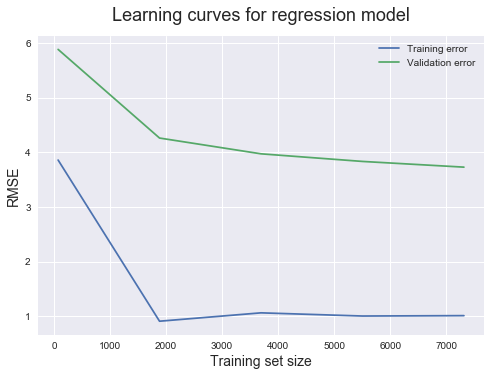

In [51]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, valid_scores_mean, label = 'Validation error')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for regression model', fontsize = 18, y = 1.03)
plt.legend()

### Building Model and Checking its Performance on an Unseen Data

### Size of the DataSet : 9146
### Size of Train DataSet : 7317 (why ? Because Model has least error for this size of dataset)
### Size of Test DataSet : 1829

In [85]:
df = pd.concat([train,target], axis=1)
x_train = df.iloc[:7317,:22].values
y_train = df.iloc[:7317,-1].values
x_test  = df.iloc[7317:,:22].values
y_actual= df.iloc[7317:,-1].values

In [86]:
reg = model.fit(x_train,y_train)

In [83]:
y_pred = reg.predict(x_test)

In [84]:
RMSE(y_actual,y_pred)

3.7498458048813794